In [1]:
import numpy as np
from numpy.random import randint,uniform,choice
import matplotlib.pyplot as plt
import datetime
import time
from params import *

In [2]:
print(rate[0][1])
print(dt)

0.4
0.1


In [3]:
def Tau_Leap_Targetted(Tpars, T, home_loc_state, quarantine_confined, test_frac,target_hcw):
    
    s = time.time()
    
    pop = np.copy(quenched_pop)
    n_per_location = np.copy(quenched_n_per_location)
    link_weight = np.copy(quenched_link_weight)
    n = np.copy(n0)
    
    test = Tpars
        
    test_result = np.zeros(n_pop,int)                # Array to hold results of test (+1 positive, -1 negative)
    
    
    loc_confined_time = np.zeros(n_loc,float)        # Time when a location was confined
    for i in range(0,n_loc):
        loc_confined_time[i] = -1000                 # Set the confined time of all locations to be "\infty"
    
    
    next_test_date = np.zeros(n_pop,int)             # Don't conduct a test before this date per person. (Initially all day 0)
    
    result_declared_date = np.zeros(n_pop,int)       # Declare the result of last test on this day (initiall -1000)    
    for i in range(0, n_pop):
        next_test_date[i] = randint(7)
        result_declared_date[i] = -1000

        
    locked = []
    
    hq_tests_conducted = 0
    lq_tests_conducted = 0
    results_declared= 0
    locations_moved = 0
    
    tests_conducted = 0
    
    t = 0.0
    
    v = np.array([[-1, 0, 0, 0, 0, 0],       # Array to denote change per state per event
                  [ 1,-1,-1, 0, 0, 0],       # The row indexes the state variables, and the
                  [ 0, 1, 0,-1,-1, 0],       # column indexes the events. The number represents
                  [ 0, 0, 1, 1, 0, 1],
                  [ 0, 0, 0, 0, 1,-1]],int)  # the change in that particular state, given an event.

    
    transitions = np.zeros((n_states,n_states),int)
    r = np.zeros(n_events)             # Empty array to store rates per event
    K = np.zeros(n_events,int)         # Empty array to store number of events that occur in dt (Poisson distributed)
    
    alpha = 1 - Cpars[5]   # Effective reduction in transmissivity of infected individuals (BOTH A and I)
    
    
    #### TESTS #################################
    
    tests_available_daily = int(test_frac/100 * n_pop)
    tests_available_now   = int(test_frac/100 * n_pop)  # test_frac% of population number of tests available
    
    lq_tests_daily      = int(test[0][3] * tests_available_daily)
    lq_tests_available  = int(test[0][3] * tests_available_daily)
    
    hq_tests_daily      = int(test[1][3] * tests_available_daily)
    hq_tests_available  = int(test[1][3] * tests_available_daily)
    
    if(lq_tests_daily + hq_tests_daily > tests_available_daily):
        print("More LQ + HQ tests available than total! Are you sure your test fractions for each test type are correct?")
        quit()
    
    lq_sensitivity = test[0][0]
    lq_specificity = test[0][1]
    lq_result_delay= test[0][2]
    
    hq_sensitivity = test[1][0]
    hq_specificity = test[1][1]
    hq_result_delay= test[0][2]
    
    ############################################
    
    output = np.append(np.append(0,n),[hq_tests_conducted,lq_tests_conducted,tests_available_now,len(locked)])
    
    day = 0
    
    while(n[1]+n[2]+n[4]>0):
#     while(t<T):
        
        for i in range(0, n_loc):                 # Loop over locations
            
            indices = np.where(pop[:,3]==i)[0]    # Index in pop of individuals in this location
            N = len(indices)
            
            if(N==0):
                continue                           # If no one's in this location, skip this loop
            
            V = N                                  # Assume one-to-one contact
            
            
            conf_by_state_in_loc = np.zeros(n_states,int) # Number of confined individuals by state in location
            
            if(quarantine_confined == True):       # If you want to reduce infectivity of confined individuals, find out how many there are
                conf_state = is_confined[indices]
                
                for m in range(0,N):               # Change the new "confined per state location" numbers
                    if(conf_state[m] == True):     # If the person is confined
                        conf_by_state_in_loc[pop[indices[m]][0]] += 1
                
    
            # This part can be done more efficiently using a matrix, but that's for later
            
            r[0] = rate[0][1] * n_per_location[i][0] * 1/V * (Cpars[1]*(n_per_location[i][1] - conf_by_state_in_loc[1]*alpha)  + Cpars[2]*(n_per_location[i][2]- conf_by_state_in_loc[2]*alpha) + Cpars[4]*n_per_location[i][4])
            r[1] = rate[1][2] * n_per_location[i][1]
            r[2] = rate[1][3] * n_per_location[i][1]
            r[3] = rate[2][3] * n_per_location[i][2]
            r[4] = rate[2][4] * n_per_location[i][2]
            r[5] = rate[4][3] * n_per_location[i][4]
            
            flag = False
            counter = 0
            
            while(flag == False):
                for j in range(0,n_events):
                    K[j] = np.random.poisson(r[j]*dt)

                transitions[0][1] = K[0]
                transitions[1][2] = K[1]
                transitions[1][3] = K[2]
                transitions[2][3] = K[3]
                transitions[2][4] = K[4]
                transitions[4][3] = K[5]

                n_removed = np.sum(transitions,axis=1) # Number of people ideally needing to be removed

                for j in range(0,n_states):
                    if( n_per_location[i][j] < n_removed[j] and n_removed[j]!=0):
                        transitions[j,:] = np.round(transitions[j,:]/n_removed[j] * n_per_location[i][j])


                K[0] = transitions[0][1]
                K[1] = transitions[1][2]
                K[2] = transitions[1][3]
                K[3] = transitions[2][3]
                K[4] = transitions[2][4]
                K[5] = transitions[4][3]

                n_per_location[i] +=  np.dot(v,K)            # Change number per location by Sum_j v_ij K_j 

                if(np.any(n_per_location[i]<0)):
                    print("Negative populations! Shouldn't be happening!")
                    print(transitions)
                    print(n_per_location[i])
                    print("Rolling back")
                    n_per_location[i] -=  np.dot(v,K)
                    print(n_per_location[i])
                    print("Trying again...")
                    counter += 1
                    
                    if counter == 9:                        # Don't let more than 10 retries occur
                        print("Fatal error: 10 retries didn't get rid of negative populations")
                        break
                else:
                    flag = True
            

            if(np.all(transitions==0)):               # Skip this loop if no transitions need to occur
                continue

            
            done = np.zeros(len(indices),bool)        # Array to make sure same individual isn't shifted more than once
            
            
            for j in range(0,n_states):
                for k in range(0,n_states):
                    l=0
                    for m in range(0,len(indices)): # Go over everyone in this location
                        if(l==transitions[j][k]):
                            break

                        if(pop[indices[m]][0] == j and not done[m]):  # If they are j
                            pop[indices[m]][0] = k    # change them to k
                            n[j] -= 1                 # Decrement number of j
                            n[k] += 1                 # Increment number of k
                            
                            if(k==3): # If they recover,
                                is_confined[indices[m]] = False # Remove any confinement, and
                                
                                # Shift them home
                                if( pop[indices[m]][3] != pop[indices[m]][1] or pop[indices[m]][3] != pop[indices[m]][2] ):
                                    
                                    n_per_location[pop[indices[m]][3]][k] -= 1
                                    pop[indices[m]][3] = pop[indices[m]][1]   # Send them home
                                    n_per_location[pop[indices[m]][3]][k] += 1
                                    
                            elif(k==4):                 # If they are hospitalised
                                h = randint(n_hospitals)
                                n_per_location[pop[indices[m]][3]][k] -= 1 # Decrement the number of hospitalised in current (HOME or WORK) location
                                
                                pop[indices[m]][3] = h # Send them to a random hospital
                                n_per_location[pop[indices[m]][3]][k] += 1 # Increment the number of hospitalised (4) in current (hospital) location
                                
                                is_confined[indices[m]] =  False # Remove confinement   
                            
                            done[m] = True            # Don't repeat this index
                            l += 1

        
        
        
        
        ##### TARGETTED TESTING ###########################################################
        
        # Test healthcare workers first (if option is chosen)
        
        
        if(target_hcw):
            
            
            np.random.shuffle(hcw)   # Shuffle list of healthcare workers
            
            
            targetted_tests_done_today = min(tests_available_now,n_hcw) # Total number of targetted tests conducted: either there are enough tests
                                                                        # in which case all hcw are tested, or all tests are exhausted on hcw
                                                                        
            
            for j in range(0,targetted_tests_done_today):
                
                i = hcw[j]                                      # Since hcw is shuffled, this is in random order
                
                if(day >= next_test_date[i] and not being_tested[i] and tests_available_now>0):
                    # If so, perform a test.
                    being_tested[i] = True            
                    tests_conducted += 1
                    
                    tests_available_now -= 1                    # Reduce number of tests available

                    
                    ### HCW are tested with HQ tests unless there are none
                    
                    test_type = 1
                    
                    if(hq_tests_available<=0):                  # If no HQ tests available
                        test_type = 0                           # Do a LQ test
                    
                    
                    if(test_type == 0 and lq_tests_available>0):

                        # Do low quality test
                        lq_tests_conducted += 1
                        lq_tests_available -= 1  # Reduce number of LQ tests
                        
                        next_test_date[i]       = day + days_bw_lq_tests   # Set date for next test

                        result_declared_date[i] = day + lq_result_delay # No of days (from today) to wait to get the result

                        if ((pop[i][0]==1 or pop[i][0]==2) 
                            and uniform(0.0,1.0)<lq_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3) 
                                                                        and uniform(0.0,1.0)>lq_specificity): # If the person is infected and the test works 

                            test_result[i] = 1

                        else:
                            test_result[i] = -1


                    elif(test_type == 1 and hq_tests_available>0):

                        # Do high quality test
                        hq_tests_conducted += 1
                        hq_tests_available -= 1

                        next_test_date[i]       = day + days_bw_hq_tests# Set date for next test
                        
                        result_declared_date[i] = day + hq_result_delay # No of days (from today) to wait to get the result

                        if ((pop[i][0]==1 or pop[i][0]==2) 
                            and uniform(0.0,1.0)<hq_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3) 
                                                                        and uniform(0.0,1.0)>hq_specificity): # If the person is infected and the test works 
                            test_result[i] = 1

                        else:
                            test_result[i] = -1
        
        
        ###################################################################################
            
            
        
        
        
        # Test Symptomatics
        
        list_of_sym = np.where(pop[:,0]==2)[0]
        
        n_sym = len(list_of_sym)
        
        if(n_sym>0):
            #sym_done = np.zeros(n_sym,bool)
            
            targetted_tests_done_today = min(tests_available_now,n_sym) # Total number of targetted tests conducted: either there are enough tests
                                                                        # in which case all symptomatics are tested, or all tests are exhausted on
                                                                        # on symptomatics
            
            np.random.shuffle(list_of_sym)                              # Shuffle the list of symptomatics so that they are chosen randomly
            
            for j in range(0,targetted_tests_done_today):
                
                i = list_of_sym[j]                                      # Since list_of_sym is shuffled, this is in random order
                
                if(day >= next_test_date[i] and not being_tested[i] and tests_available_now>0):
                    # If so, perform a test.
                    being_tested[i] = True            
                    tests_conducted += 1
                    
                    tests_available_now -= 1                    # Reduce number of tests available

                    
                    ### Susceptibles are tested with HQ tests unless there are none
                    
                    test_type = 1
                    
                    if(hq_tests_available<=0):                  # If no HQ tests available
                        test_type = 0                           # Do a LQ test
                    
                    
                    if(test_type == 0):

                        # Do low quality test
                        lq_tests_conducted += 1
                        lq_tests_available -= 1  # Reduce number of LQ tests
                        
                        next_test_date[i]       = day + days_bw_lq_tests   # Set date for next test

                        result_declared_date[i] = day + lq_result_delay # No of days (from today) to wait to get the result

                        if ((pop[i][0]==1 or pop[i][0]==2) 
                            and uniform(0.0,1.0)<lq_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3) 
                                                                        and uniform(0.0,1.0)>lq_specificity): # If the person is infected and the test works 

                            test_result[i] = 1

                        else:
                            test_result[i] = -1


                    elif(test_type == 1):

                        # Do high quality test
                        hq_tests_conducted += 1
                        hq_tests_available -= 1

                        next_test_date[i]       = day + days_bw_hq_tests# Set date for next test
                        
                        result_declared_date[i] = day + hq_result_delay # No of days (from today) to wait to get the result

                        if ((pop[i][0]==1 or pop[i][0]==2) 
                            and uniform(0.0,1.0)<hq_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3) 
                                                                        and uniform(0.0,1.0)>hq_specificity): # If the person is infected and the test works 
                            test_result[i] = 1

                        else:
                            test_result[i] = -1
        
        
        ###################################################################################
                            

        for i in range(0,n_pop): 
            
            #### TESTING ###########################################
            
            p = test_frac/100     # Probability of testing someone (random)
            
            if (day >= next_test_date[i] and not being_tested[i] 
                and uniform(0.0,1.0) < p and tests_available_now>0): # Check if person i should be tested
                
                # If so, perform a test.
                being_tested[i]   = True            
                tests_conducted  += 1
                
                tests_available_now -= 1                     # Reduce number of tests available
                
                test_type = choice([0,1])                    # Choose HQ or LQ test randomly
                
                if(test_type == 0 and lq_tests_available<=0):   # If a LQ test is chosen but no LQ tests available
                    test_type = 1                               # Do a HQ test
                    
                elif(test_type == 1 and hq_tests_available<=0): # If a HQ test is chosen but no HQ tests available
                    test_type = 0                               # Do a LQ test
                    
#                     print("Error! There seem to be tests available but no LQ or HQ tests are available.")
                # One of the above must happen: if no tests are available, this condition should not run in the first place
                
                
                if(test_type == 0 and lq_tests_available>0):
                    
                    # Do low quality test    
                    lq_tests_conducted += 1
                    lq_tests_available -= 1  # Reduce number of LQ tests
                    
                    next_test_date[i]       = day + days_bw_lq_tests   # Set date for next test
                    
                    result_declared_date[i] = day + lq_result_delay # No. of days (from today) to wait to get the result
                
                    if ((pop[i][0]==1 or pop[i][0]==2) 
                        and uniform(0.0,1.0)<lq_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3) 
                                                                    and uniform(0.0,1.0)>lq_specificity): # If the person is infected and the test works 

                        test_result[i] = 1

                    else:
                        test_result[i] = -1
                    
                    
                elif(test_type == 1 and hq_tests_available>0):
                    
                    # Do high quality test
                    hq_tests_conducted += 1
                    hq_tests_available -= 1  # Reduce number of HQ tests
                    
                    next_test_date[i]       = day + days_bw_hq_tests  # Set date for next test
                    
                    result_declared_date[i] = day + hq_result_delay   # No of days (from today) to wait to get the result
                    
                    if ((pop[i][0]==1 or pop[i][0]==2) 
                        and uniform(0.0,1.0)<hq_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3) 
                                                                    and uniform(0.0,1.0)>hq_specificity): # If the person is infected and the test works 
                        test_result[i] = 1

                    else:
                        test_result[i] = -1
                
                
            #### DONE TESTING ######################################
            
            
            #### DECLARING RESULTS #################################
            
            if (day == result_declared_date[i] and being_tested[i]):  # Should we declare the person's results?
                
                # If so, set them to not being_tested
                being_tested[i] = False
                
                results_declared += 1
                
                # Declare results
                
                if (test_result[i] == 1 and pop[i][0]!=4):             # If they tested positive AND are now not in a hospital
                    
                    is_confined[i] = True                              # Confine them 
                    
                    n_per_location[pop[i][3]][pop[i][0]] -= 1          # Decrement number of person's state in current (NET or HOME) location of person
                    
                    if(pop[i][3] == pop[i][2]):                        # If they're at work
                        pop[i][3] = pop[i][1]                          # send them home
                    
                    n_per_location[pop[i][3]][pop[i][0]] += 1          # Increment number of person's state in current location (now HOME) of person

                    loc_confined[pop[i][1]] = home_loc_state           # Confine their home location for total_loc_confined_time (?) days
                    loc_confined_time[pop[i][1]] = t                   # Time when location is confined

                elif(test_result[i] == -1 or pop[i][0] == 4):          # If the test result is negative OR if the person's moved to the hospital
                    
                    is_confined[i] = False                             # If result is negative, let them move about
        
                test_result[i] = 0                                     # Set test_result back to 0      
            
            
            #### DONE DECLARING RESULTS ############################
            
        
            #### MOVE PEOPLE AROUND ################################  
        
            if (not is_confined[i] and not loc_confined[pop[i][3]]):  # If they aren't confined AND their CURRENT location isn't confined
                # Should this be poisson distributed? (UNSURE ABOUT THIS!)
                locs_changed = np.random.poisson( link_weight[i]*dt ) % 2 # Net number of locations changed in time dt. 
                                                                          # (An even number means you get back to where you were)
                
                locations_moved += locs_changed
                
                if(locs_changed==1):
                    home_loc = pop[i][1]
                    net_loc  = pop[i][2]

                    if(pop[i][3]==home_loc):                       # If the person is at home
                        pop[i][3] = net_loc                        # move them to their network location
                        
                        n_per_location[home_loc][pop[i][0]] -= 1   # Reduce number of individual's state at home
                        n_per_location[ net_loc][pop[i][0]] += 1   # Increase number of individual's state at work
                    
                    elif(pop[i][3]==net_loc):
                        pop[i][3] = home_loc                       # otherwise move them home
                        
                        n_per_location[ net_loc][pop[i][0]] -= 1   # Reduce number of individual's state at work
                        n_per_location[home_loc][pop[i][0]] += 1   # Increase number of individual's state at home

                   # If they're in any other location, keep them there.
    
        
        # Lock or unlock homes
        
        for i in range(0,n_loc):
            if(loc_confined[i]==True and t - loc_confined_time[i] > total_loc_confined_time):  # If the current time - the time it was last confined is > 10 days
                loc_confined_time[i] = -1000                        
                loc_confined[i] = False                             # Remove confinement restriction
                #print(str(i)+" Un-loc-ed (Haha) at "+str(t))
                locked.append(i)
           
            
        t += dt
        
        output = np.vstack((output, np.append(np.append(t,n),[hq_tests_conducted,lq_tests_conducted,tests_available_now,len(locked)])))
        
        if(t>day):
            day += 1
            tests_available_now = tests_available_daily
            lq_tests_available  = lq_tests_daily
            hq_tests_available  = hq_tests_daily
#             print(day, end=" ")
        
    plt.hist(locked)
    plt.show()
    if(len(locked)!=0):
        print("# Lowest loc "+str(min(locked)))
        print("# Highest loc "+str(max(locked)))
    
    print("# LQ Tests Done in total  : "+str(lq_tests_conducted))
    print("# HQ Tests Done in total  : "+str(hq_tests_conducted))
    print("# ALL Tests Done in total : "+str(tests_conducted))
    print("# Results Given in total  : "+str(results_declared))
    print("# Locations Moved in total: "+str(locations_moved))
    
    e = time.time()
    print("# Time taken              : "+str(round(e-s,2))+"s")
    
    ### WRITE OUTPUT TO FILE #####################
    
    date = datetime.datetime.now()
    dateString = date.strftime("%Y-%b-%d_%H-%M-%S")
    
    fileName = "../data/TargettedTesting/Targetted_Testing_"+str(round(test_frac,1))+"_RAT_"+str(round(test[0][0],1))+"_"+str(round(test[0][3],1))+"_PCR_"+str(round(test[1][0],2))+"_"+str(round(test[1][3],1))+"_"+dateString+".txt"
    
    with open(fileName, "a") as file:
        file.write("###### TEST LOG ####################\n")
        file.write("# Time taken               : "+str(round(e-s,2))+"s \n")
        
        file.write("# Test Parameters: \n")
        file.write("# "+str(test[0][0])+" "+str(test[0][1])+" "+str(test[0][2])+" "+str(test[0][3])+"\n")
        file.write("# "+str(test[1][0])+" "+str(test[1][1])+" "+str(test[1][2])+" "+str(test[1][3])+"\n")
        file.write("# Homes Quarantined        : "+ str(home_loc_state)+"\n")
        file.write("# Confined less Infective  : "+ str(quarantine_confined)+"\n")
        file.write("# Target Healthcare Workers: "+ str(target_hcw)+"\n")
        file.write("# Fraction Tested Daily    : "+ str(test_frac)+"\n")
        
        if(len(locked)!=0):
            file.write("# Lowest location confined :"+str(min(locked))+"\n")
            file.write("# Highest location confined:"+str(max(locked))+"\n")
        file.write("# LQ Tests Done in total   : "+str(lq_tests_conducted)+"\n")
        file.write("# HQ Tests Done in total   : "+str(hq_tests_conducted)+"\n")
        file.write("# ALL Tests Done in total  : "+str(tests_conducted)+"\n")
        file.write("# Results Given in total   : "+str(results_declared)+"\n")
        file.write("# Locations Moved in total : "+str(locations_moved)+"\n")
        file.write("###### END LOG #####################\n")
        file.write("#\n")
        
        np.savetxt(file, output, delimiter=" ")
    
    #return output

[0. 1.]


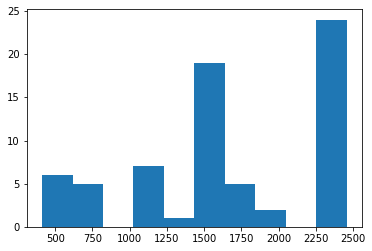

# Lowest loc 413
# Highest loc 2456
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 20569
# ALL Tests Done in total : 20569
# Results Given in total  : 20569
# Locations Moved in total: 364303
# Time taken              : 196.29s


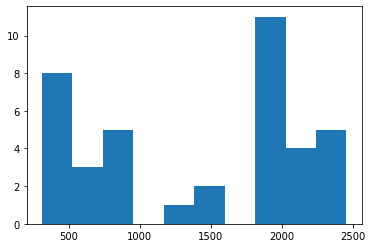

# Lowest loc 312
# Highest loc 2456
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 20383
# ALL Tests Done in total : 20383
# Results Given in total  : 20383
# Locations Moved in total: 245354
# Time taken              : 153.9s


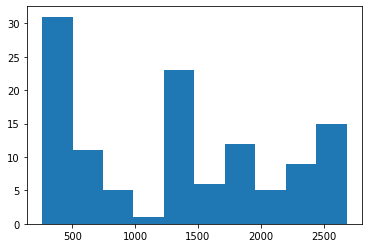

# Lowest loc 261
# Highest loc 2683
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 39130
# ALL Tests Done in total : 39130
# Results Given in total  : 39130
# Locations Moved in total: 349463
# Time taken              : 231.64s


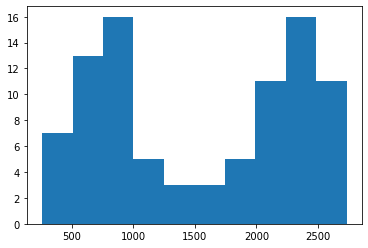

# Lowest loc 261
# Highest loc 2732
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 297871
# ALL Tests Done in total : 297871
# Results Given in total  : 297871
# Locations Moved in total: 543651
# Time taken              : 386.24s


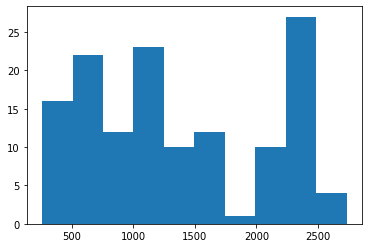

# Lowest loc 261
# Highest loc 2732
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 38064
# ALL Tests Done in total : 38064
# Results Given in total  : 38064
# Locations Moved in total: 680951
# Time taken              : 645.54s


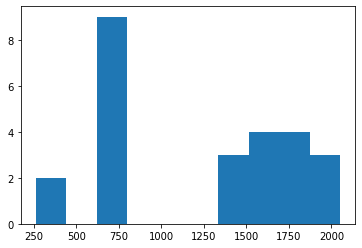

# Lowest loc 261
# Highest loc 2051
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 17374
# ALL Tests Done in total : 17374
# Results Given in total  : 17374
# Locations Moved in total: 207843
# Time taken              : 193.5s


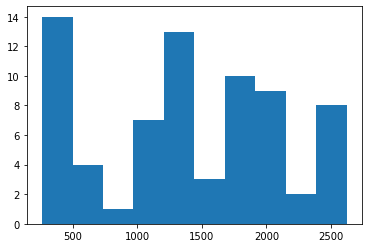

# Lowest loc 261
# Highest loc 2622
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 59142
# ALL Tests Done in total : 59142
# Results Given in total  : 59142
# Locations Moved in total: 527527
# Time taken              : 489.17s


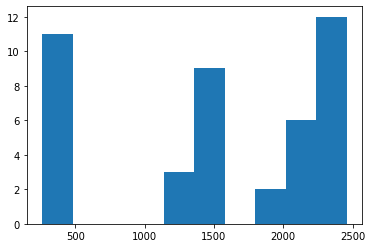

# Lowest loc 261
# Highest loc 2456
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 212814
# ALL Tests Done in total : 212814
# Results Given in total  : 212814
# Locations Moved in total: 384317
# Time taken              : 383.42s


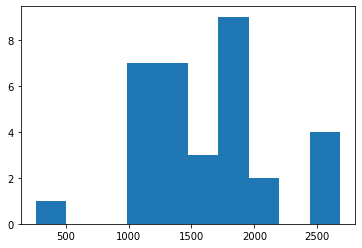

# Lowest loc 261
# Highest loc 2683
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 13560
# ALL Tests Done in total : 13560
# Results Given in total  : 13560
# Locations Moved in total: 240145
# Time taken              : 249.17s


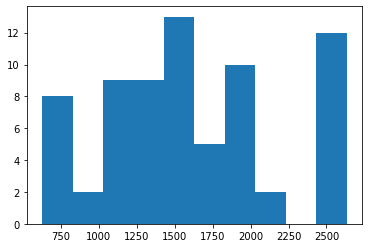

# Lowest loc 627
# Highest loc 2632
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 42853
# ALL Tests Done in total : 42853
# Results Given in total  : 42853
# Locations Moved in total: 513877
# Time taken              : 516.44s


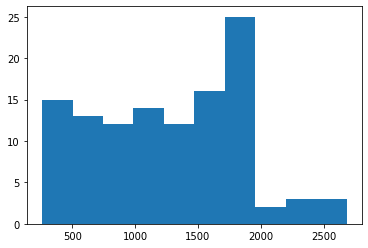

# Lowest loc 261
# Highest loc 2683
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 74138
# ALL Tests Done in total : 74138
# Results Given in total  : 74138
# Locations Moved in total: 664027
# Time taken              : 533.52s


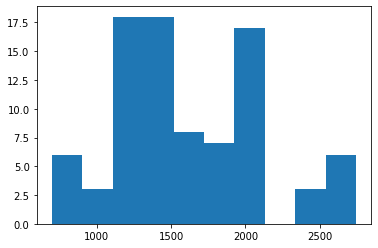

# Lowest loc 698
# Highest loc 2745
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 252742
# ALL Tests Done in total : 252742
# Results Given in total  : 252742
# Locations Moved in total: 453611
# Time taken              : 340.97s


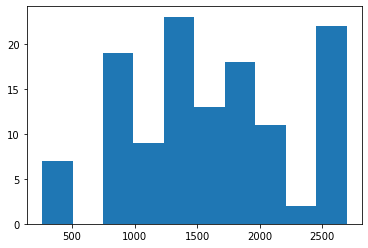

# Lowest loc 261
# Highest loc 2696
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 48091
# ALL Tests Done in total : 48091
# Results Given in total  : 48091
# Locations Moved in total: 871776
# Time taken              : 853.36s


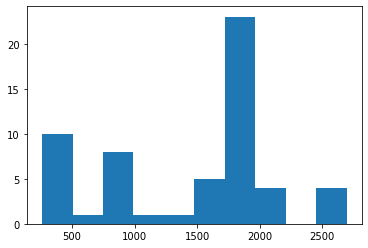

# Lowest loc 261
# Highest loc 2696
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 21868
# ALL Tests Done in total : 21868
# Results Given in total  : 21868
# Locations Moved in total: 257515
# Time taken              : 229.27s


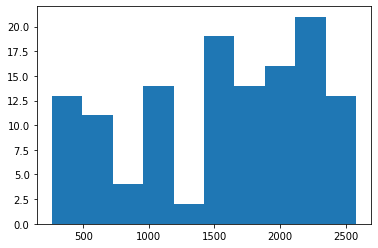

# Lowest loc 261
# Highest loc 2581
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 91149
# ALL Tests Done in total : 91149
# Results Given in total  : 91149
# Locations Moved in total: 824651
# Time taken              : 18626.11s


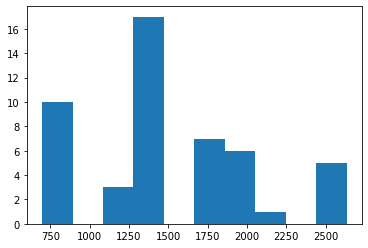

# Lowest loc 698
# Highest loc 2632
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 312795
# ALL Tests Done in total : 312795
# Results Given in total  : 312795
# Locations Moved in total: 571218
# Time taken              : 332.02s


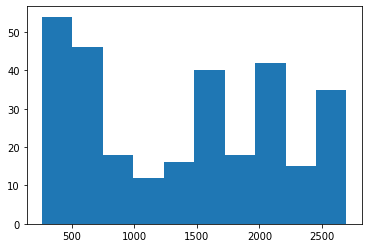

# Lowest loc 261
# Highest loc 2696
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 64574
# ALL Tests Done in total : 64574
# Results Given in total  : 64574
# Locations Moved in total: 1161891
# Time taken              : 585.65s


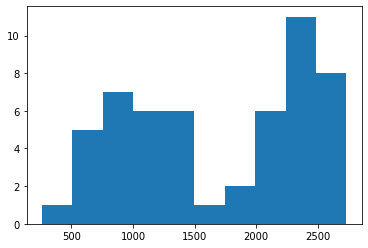

# Lowest loc 261
# Highest loc 2732
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 36099
# ALL Tests Done in total : 36099
# Results Given in total  : 36099
# Locations Moved in total: 427572
# Time taken              : 246.69s


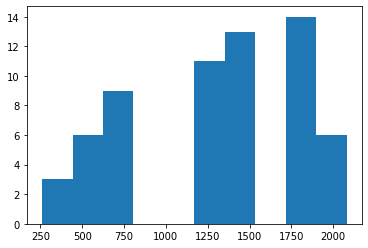

# Lowest loc 261
# Highest loc 2079
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 48155
# ALL Tests Done in total : 48155
# Results Given in total  : 48155
# Locations Moved in total: 427916
# Time taken              : 171.22s


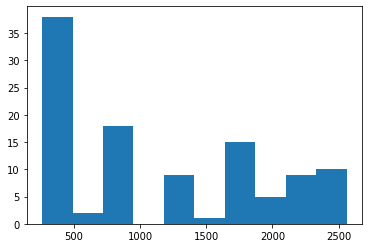

# Lowest loc 261
# Highest loc 2560
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 237739
# ALL Tests Done in total : 237739
# Results Given in total  : 237739
# Locations Moved in total: 432479
# Time taken              : 143.64s


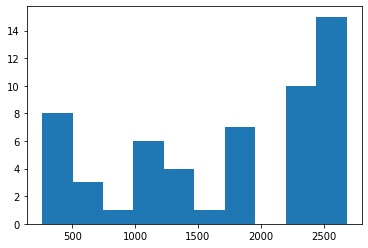

# Lowest loc 261
# Highest loc 2683
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 17077
# ALL Tests Done in total : 17077
# Results Given in total  : 17077
# Locations Moved in total: 306256
# Time taken              : 102.21s


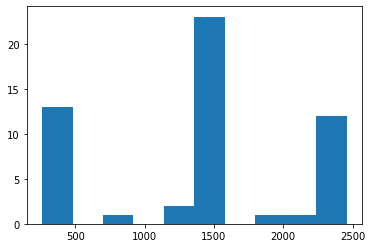

# Lowest loc 261
# Highest loc 2456
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 19603
# ALL Tests Done in total : 19603
# Results Given in total  : 19603
# Locations Moved in total: 234460
# Time taken              : 78.95s


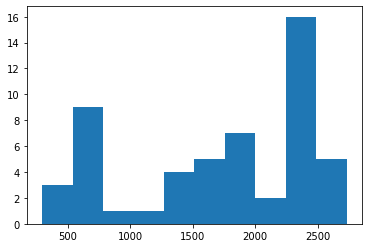

# Lowest loc 297
# Highest loc 2732
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 41120
# ALL Tests Done in total : 41120
# Results Given in total  : 41120
# Locations Moved in total: 367329
# Time taken              : 123.91s


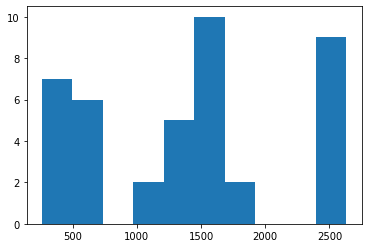

# Lowest loc 261
# Highest loc 2632
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 392689
# ALL Tests Done in total : 392689
# Results Given in total  : 392689
# Locations Moved in total: 710448
# Time taken              : 233.86s


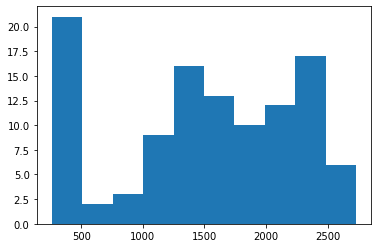

# Lowest loc 261
# Highest loc 2732
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 24071
# ALL Tests Done in total : 24071
# Results Given in total  : 24071
# Locations Moved in total: 426533
# Time taken              : 168.25s


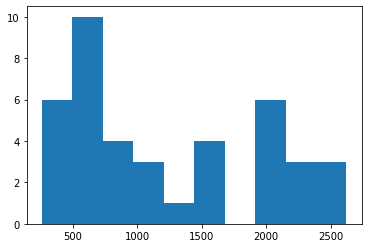

# Lowest loc 261
# Highest loc 2622
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 23361
# ALL Tests Done in total : 23361
# Results Given in total  : 23361
# Locations Moved in total: 279756
# Time taken              : 158.23s


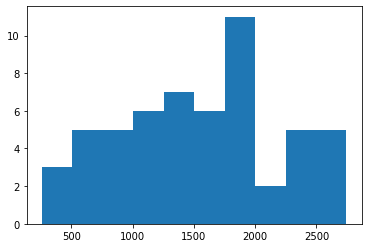

# Lowest loc 261
# Highest loc 2745
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 36143
# ALL Tests Done in total : 36143
# Results Given in total  : 36143
# Locations Moved in total: 327629
# Time taken              : 151.39s


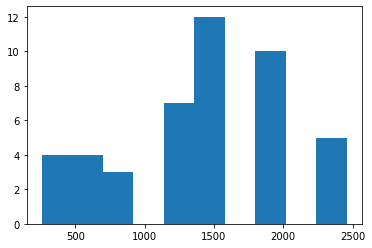

# Lowest loc 261
# Highest loc 2456
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 87804
# ALL Tests Done in total : 87804
# Results Given in total  : 87804
# Locations Moved in total: 163609
# Time taken              : 93.87s


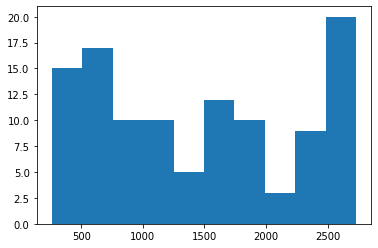

# Lowest loc 261
# Highest loc 2732
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 31563
# ALL Tests Done in total : 31563
# Results Given in total  : 31563
# Locations Moved in total: 563910
# Time taken              : 195.49s


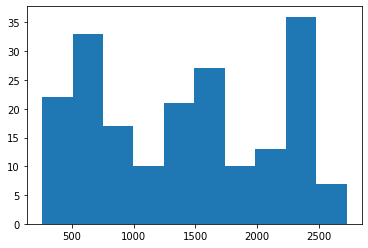

# Lowest loc 261
# Highest loc 2722
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 60863
# ALL Tests Done in total : 60863
# Results Given in total  : 60863
# Locations Moved in total: 727358
# Time taken              : 349.4s


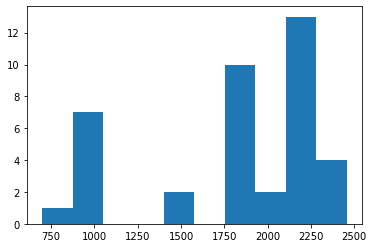

# Lowest loc 698
# Highest loc 2456
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 35134
# ALL Tests Done in total : 35134
# Results Given in total  : 35134
# Locations Moved in total: 314948
# Time taken              : 203.53s


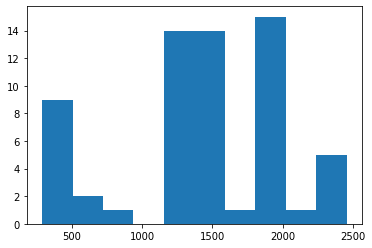

# Lowest loc 288
# Highest loc 2456
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 217711
# ALL Tests Done in total : 217711
# Results Given in total  : 217711
# Locations Moved in total: 397435
# Time taken              : 192.31s


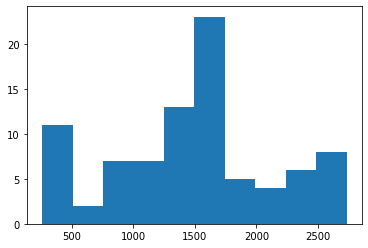

# Lowest loc 261
# Highest loc 2732
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 23562
# ALL Tests Done in total : 23562
# Results Given in total  : 23562
# Locations Moved in total: 424067
# Time taken              : 163.08s


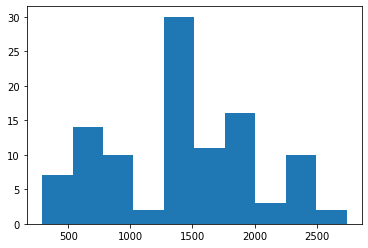

# Lowest loc 288
# Highest loc 2742
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 79598
# ALL Tests Done in total : 79598
# Results Given in total  : 79598
# Locations Moved in total: 960876
# Time taken              : 626.54s


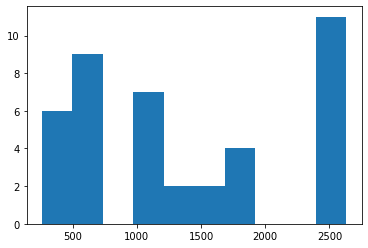

# Lowest loc 261
# Highest loc 2632
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 54147
# ALL Tests Done in total : 54147
# Results Given in total  : 54147
# Locations Moved in total: 489167
# Time taken              : 238.85s


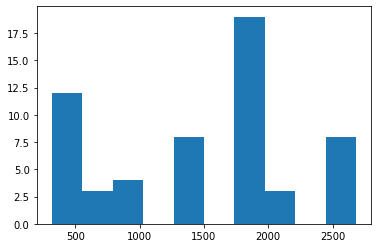

# Lowest loc 317
# Highest loc 2683
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 142825
# ALL Tests Done in total : 142825
# Results Given in total  : 142825
# Locations Moved in total: 259803
# Time taken              : 106.64s


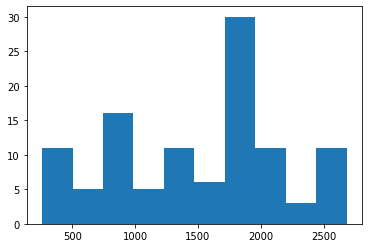

# Lowest loc 261
# Highest loc 2683
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 19069
# ALL Tests Done in total : 19069
# Results Given in total  : 19069
# Locations Moved in total: 342646
# Time taken              : 119.48s


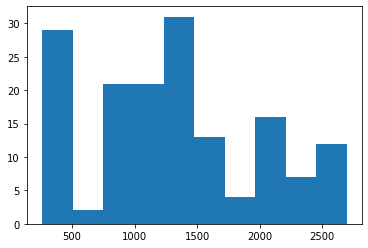

# Lowest loc 261
# Highest loc 2696
# LQ Tests Done in total  : 0
# HQ Tests Done in total  : 87107
# ALL Tests Done in total : 87107
# Results Given in total  : 87107
# Locations Moved in total: 1051162
# Time taken              : 613.03s


KeyboardInterrupt: 

In [4]:
# IMPORT POPULATION #######################

quenched_pop            = np.genfromtxt('./quenched_pop.txt', delimiter=' ',dtype=int,comments="#")
quenched_n_per_location = np.genfromtxt('./quenched_n_per_location.txt', delimiter=' ',dtype=int,comments="#")
quenched_link_weight    = np.genfromtxt('./quenched_linkweight.txt', delimiter=' ',dtype=int,comments="#")

# Getting list of healthcare workers: people whose work location is < n_hospitals

hcw = np.where(quenched_pop[:,2]<n_hospitals)[0]
n_hcw = len(hcw)



###########################################

Tpars  = np.array([[0.6, 1, 0, 1],          # Low quality: sensitivity, specificity, result delay, Fraction of tests
                   [1.0, 1, 0, 0]])         # High quality: sentitivity, specificity, result delay, Fraction of tests



tf=100

test_rates = [5, 7.5, 10, 50]

p = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])   # Fraction of LQ tests

for f in p:
    Tpars[:,3] = [f, round(1-f,2)]
    print(Tpars[:,3])
    
    for i in range(0,10):
        for daily_rate in test_rates:
            Tau_Leap_Targetted(Tpars, tf, True, True, daily_rate,False)
